## 4 - Hexagons
>Maps using hexagonal grids. Step away from square grids and try mapping with hexagons. A fun way to show density or spatial patterns. 🔷

- density of (non)natural springs across hungary

In [45]:
import cartopy.crs as ccrs
import h3
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import Polygon, box, LineString, Point
from shapely.ops import unary_union
import numpy as np
from matplotlib.colors import Normalize, LogNorm
import matplotlib.patheffects as path_effects
from itertools import product
import pandas as pd

ox.settings.max_query_area_size = 6e12

In [2]:
## helper for filling shapely polygon (in lat lon) with h3 hexagons
# returns geodataframe of hexagon 
def fill_poly_with_hexagons(geometry, resolution=5):
    
    x, y = geometry.exterior.coords.xy
    h3_oly = h3.LatLngPoly(list(zip(y,x)))
    h3_hexes = h3.polygon_to_cells(h3_oly, resolution)
    h3_dicts = [h3.cells_to_geo([h]) for h in h3_hexes]
    polygons = [Polygon(h3dict['coordinates'][0]) for h3dict in h3_dicts]
    gdf = gpd.GeoDataFrame({'hex': h3_hexes},
                           geometry=polygons,
                           crs=4326)
    
    return gdf    

In [3]:
# get data

# hungarian border
aoi = ox.geocode_to_gdf('Hungary')
utm_crs = aoi.estimate_utm_crs()
aoi_utm = aoi.to_crs(utm_crs)

# get h3 hexagons that fill the aoi
gdf = (fill_poly_with_hexagons(aoi.geometry[0],
                              resolution=5)
       .to_crs(utm_crs))

outline = unary_union(gdf.geometry.tolist()).exterior

# natural springs
springs = (ox.features_from_polygon(aoi.geometry[0],
                                   tags={'natural':'spring'})
           .loc['node'][['geometry']]
           .to_crs(utm_crs))

# pubs and bars
pubs = (ox.features_from_polygon(aoi.geometry[0],
                                   tags={'amenity':'bar',
                                         'amenity': 'pub'})
        .loc['node'][['geometry']]
        .to_crs(utm_crs))

# cities
cities = (ox.features_from_polygon(aoi.geometry[0],
                                  tags={'capital':['yes', '1', '2', '3', '4', '5', '6']})
          .loc['node'][['geometry','name']]
          .to_crs(utm_crs))


In [ ]:
# count springs/pubs in each hexagon
spring_count = (gpd.sjoin(springs,
                          gdf)
                .groupby('hex')
                .count()
                .drop(columns='index_right')
                .rename(columns={'geometry':'spring_count'})
)

pub_count = (gpd.sjoin(pubs,
                       gdf)
             .groupby('hex')
             .count()
             .drop(columns='index_right')
             .rename(columns={'geometry':'pub_count'})
)

# merge the counts into single gdf
gdf = (gdf
       .merge(spring_count,
              left_on='hex',
              right_index=True,
              how='outer')
       .merge(pub_count,
              left_on='hex',
              right_index=True,
              how='outer'
              )
)

# replace nans with zero
gdf.loc[gdf['spring_count'].isna(), 'spring_count'] = 0
gdf.loc[gdf['pub_count'].isna(), 'pub_count'] = 0

# because sometimes plotting on log scale add one to everything
gdf['spring_count'] += 1
gdf['pub_count'] += 1

# cut and group pub_count and spring_count into 4 equal quantiles.
# and assign a group id

gdf['pub_group'] = (pd.qcut(gdf['pub_count'], 4, duplicates='drop')
                    .apply(lambda interval: interval.mid)
                    .rank(method='dense')
                    .astype(int) - 1)

# for spring - the very skewed distribution meant need to increase 
# `q`` param 4 to 7 to have enough non-duplicate groups
gdf['spring_group'] = (pd.qcut(gdf['spring_count'], 7, duplicates='drop')
                       .apply(lambda interval: interval.mid)
                       .rank(method='dense')
                       .astype(int) - 1)

# double check that there are 4 groups in both counts
assert (gdf['spring_group'].max()==3) & (gdf['pub_group'].max()==3), 'not enough/too many groups. tweak `q` in `pd.qcut()`'

# make tuple that will define what color on the bivariate colormap is needed
gdf['group'] = tuple(zip(gdf['pub_group'], gdf['spring_group']))

# select colors from colormap
# deliberately biasing these towards the lighter end
# as the multiplication tends to darken things
pub_colors = plt.get_cmap('Oranges')([0.15, 0.3, 0.45, 0.6])
spr_colors = plt.get_cmap('Blues')([0.15, 0.3, 0.45, 0.6])
bivar_colors = []

# combine colors
for a, b in product(pub_colors, spr_colors):
    value = np.multiply(list(a), list(b))
    bivar_colors.append(value)

# make a color dictionary that will then map to group tuple
color_dict = dict(zip(list(product(range(4),
                                   range(4))),
                      bivar_colors))

gdf['color'] = gdf['group'].map(color_dict)


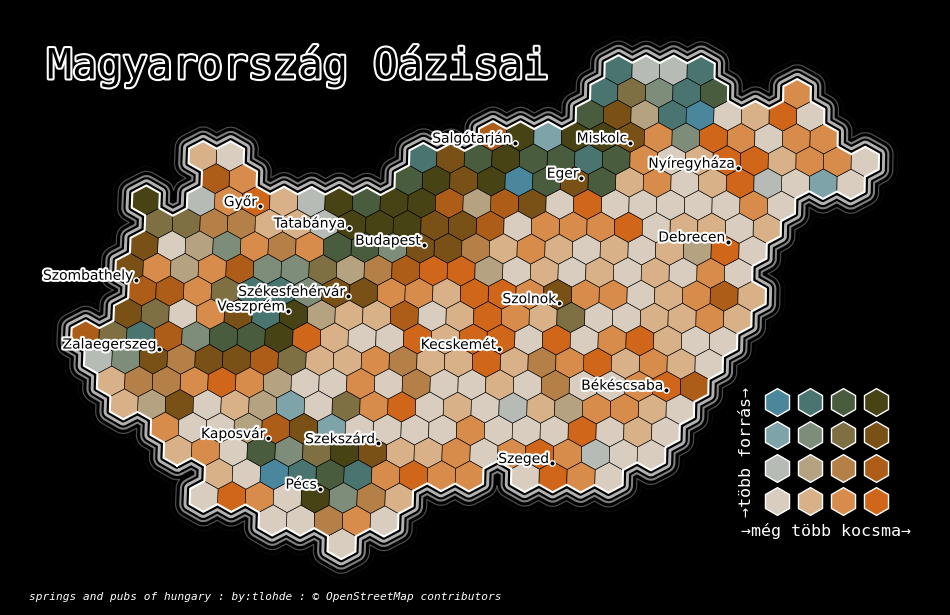

In [61]:
# do the plotting
fig = plt.figure(figsize=[12,12])

ax = fig.add_subplot(111) #, projection=ccrs.epsg(utm_crs.to_epsg()))

gdf.plot(facecolor=gdf['color'],
         edgecolor='k',
         linewidths=0.4,
         ax=ax)

ax.plot(*outline.coords.xy, c='w')

for buff, alph in zip([3000, 6000, 9000, 12000],
                      [0.7, 0.5, 0.3, 0.1]):
    ax.plot(*outline.buffer(buff).exterior.coords.xy,
            c='w', alpha=alph, lw=alph*3)

cities.plot(c='k',
            marker='o',
            ec='w',
            markersize=15,
            ax=ax, )

for row in cities.itertuples():    
    ax.annotate(
        row.name,
        xy=(row.geometry.x, row.geometry.y),
        xytext=(-2,0),
        textcoords='offset points',
        c='k',
        ha='right',
        path_effects=[path_effects.Stroke(linewidth=3,
                                          foreground='w'),
                      path_effects.Normal()])
    
ax.set_title('Magyarország Oázisai',
             y=0.87, x=0.31, color='k',
             fontdict={'family':'DejaVu Sans Mono',
                       'size':30},
             path_effects=[path_effects.Stroke(linewidth=3,
                                               foreground='w'),
                           path_effects.Normal()])

ax.annotate('springs and pubs of hungary : by:tlohde : © OpenStreetMap contributors',
            xy=(0.02, 0.01),
            xycoords='axes fraction',
            font='DejaVu Sans Mono',
            fontstyle='italic',
            color='w',
            fontsize=8)

ax.set_axis_off()

### legend
cax = fig.add_axes([0.75,0.32,0.11,0.11],
                   facecolor='k')
for xy, c in color_dict.items():
    x, y = xy
    cax.scatter(x, y, color=c, s=400, marker='h', ec='w')

cax.set(
    xlim=(-0.5, 3.5),
    ylim=(-0.5, 3.5),
    xticks=[],
    yticks=[],
)

cax.set_ylabel('→több forrás→',
               color='w',
               fontdict={'family':'DejaVu Sans Mono', 'size':12})
cax.set_xlabel('→még több kocsma→',
               color='w',
               fontdict={'family':'DejaVu Sans Mono', 'size':12})

cax.set_aspect('equal')
cax.spines[:].set_visible(False)

fig.patch.set_facecolor('k')

In [62]:
fig.savefig('day4.png', dpi=300, bbox_inches='tight', pad_inches=0.2)